# COVID-19 and Infection Rate:
## Linear Regression Analysis

### Introduction

Of key interest in tracking an infectious outbreak is the rate at which the infection is spreading in the general population. This rate is represented in epidemeological work to as `R₀`. Basically, `R₀` represents the number of new infections that arise from each existing infection. An `R₀` above 1 means an infection is spreading; and `R₀` below 1 means that it is dying out.

I am not an epidemeologist. Fortunately, there are people in this world who are, and these people tend to write papers. In *Data-based analysis, modelling and forecasting of the COVID-19 outbreak*, Cleo Anastassopoulou, Lucia Russo, Athanasios Tsakris, and Constantinos Siettos provide a series of equations that are useful in modeling the COVID-19 outbreak using the Susceptible-Infectious-Recovered-Dead (**SIDR**) model.

Since COVID-19 is a novel virus, we assume that the number of **Susceptible** people equals the total population; nobody starts off with immunity to this virus. As people get the virus, they go from being **Susceptible** **Infectious**. **Infectious** people can spread the disease to **Suseptible** people. As the disease progresses, a **Infectious** individual ultimately falls into one of two categories: **Recovered**, meaning they no longer have the disease, and **Dead**, meaning they, too, no longer have the disease, albeit for different reasons. For the purposes of this model, we'll assume that all **Recovered** individuals are immune to reinfection.

Today, I'll be using *Anastassopoulou et. al.* as a starting point for creating my own simple COVID-19 model.

### Setup

As usual, we'll import some common libraries, such as `pandas`, `matplotlib`, `math`, and `numpy`. We'll also load our data from *The COVID Project*'s daily totals API.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

# Having trouble connecting to external data sources today. Attempting to compensate.
#covidDF = pd.read_csv("https://covidtracking.com/api/us/daily.csv")
covidDF = pd.read_csv("data/COVID19_US_APRIL_8.csv")

# re-order the data, oldest to newest
covidDF = covidDF.sort_index(ascending=False) # sort by index, descending
covidDF = covidDF.reset_index(drop=True)
covidDF.head(25)

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200228,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,NaN,9,9,9,NaN,NaN,NaN,NaN,NaN
1,20200229,1,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5,NaN,18,18,18,1.0,0.0,0.0,9.0,9.0
2,20200301,2,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8,NaN,31,31,31,3.0,0.0,0.0,13.0,13.0
3,20200302,2,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11,NaN,35,35,35,3.0,0.0,0.0,4.0,4.0
4,20200303,2,60,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,14,NaN,66,66,66,3.0,0.0,6.0,25.0,31.0
5,20200304,15,157,759.0,103.0,NaN,NaN,NaN,NaN,NaN,...,16,NaN,1019,916,916,2.0,0.0,753.0,97.0,850.0
6,20200305,25,204,970.0,197.0,NaN,NaN,NaN,NaN,NaN,...,20,NaN,1371,1174,1174,4.0,0.0,211.0,47.0,258.0
7,20200306,37,296,1588.0,458.0,NaN,NaN,NaN,NaN,NaN,...,26,NaN,2342,1884,1884,6.0,0.0,618.0,92.0,710.0
8,20200307,51,421,1839.0,602.0,NaN,NaN,NaN,NaN,NaN,...,27,NaN,2862,2260,2260,1.0,0.0,251.0,125.0,376.0
9,20200308,51,562,2335.0,347.0,NaN,NaN,NaN,NaN,NaN,...,31,NaN,3244,2897,2897,4.0,0.0,496.0,141.0,637.0


We can plot some interesting graphs with this data, such as the number of tests added each day:

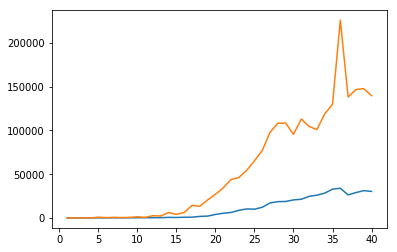

In [2]:
plt.plot(covidDF.index, covidDF.positiveIncrease)
plt.plot(covidDF.index, covidDF.totalTestResultsIncrease)

...and the daily rate of positive tests per total tests:

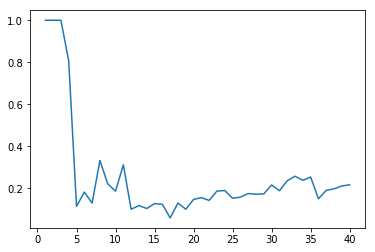

In [3]:
plt.plot(covidDF.index, (covidDF.positiveIncrease / covidDF.totalTestResultsIncrease))

One thing that becomes immediately apparent is that in the early days of testing, there's a great amount of variability, most likely due to the limited numbers of tests performed and growing pains for reporting these data.

Let's restrict our dataset by tracking starting from day 13, the first day over 10,000 tests were reported.

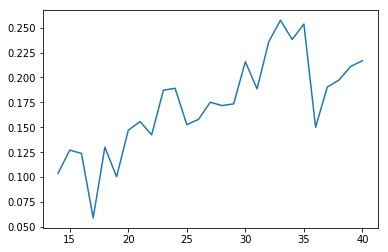

In [4]:
covidDF = covidDF[covidDF['totalTestResults'] > 10000]
plt.plot(covidDF.index, (covidDF.positiveIncrease / covidDF.totalTestResultsIncrease))

That's a bit better! While there's still some variation, it's much less messy at the start of the graph.

Now, let's look at some equations that'll help us do a linear regression of this data.

**Susceptible**

For the purposes of this exercise, we'll use the total population of the United States, approximately 331 million.

**Infected**, **Recovered**, and **Dead**

These values will all start from zero.

## Modelling the infection

We've got two key variables in tracking how our infection is spread: the period for which a person is infectious, and `R₀`, the number of people an infected person will transfer the disease to during that infectious period.

With these two variables, we can create a very simple model for how the disease will spread. There are, however,  other considerations to be made. For example, if people are actively isolating themselves from social contact, that can have a significant impact on the rate at which the disease can be transmitted. Let's add a third variable, `isolationRate`, to our model. `isolationRate` is indicative of how much of the population is exposed to the virus on any given day. At first, isolation rate doesn't have much of an effect, but as the number of suceptible people drops and the number of infected people grows, we begin to see results.



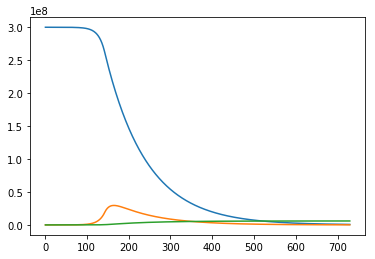

In [5]:
sirdModelDF = pd.DataFrame(np.array([[0, 300000000.0, 1000.0, 0.0, 0.0]]), columns=['Day', 'Suceptible', 'Infected', 'Recovered', 'Dead'])

infectiousPeriod = 14
rNaught = 2.0

def CalculateDailyInfected(sirdDataframe, infectPeriod, r0, deathRate, isolationRate, daysToRun):
    workingDF = sirdDataframe.head(1) # drop any extraneous data
    workingDF = pd.concat([workingDF]*daysToRun)
    workingDF = workingDF.reset_index(drop=True)
    
    totalPeople = workingDF.at[0,"Suceptible"] + workingDF.at[0,"Infected"] + workingDF.at[0,"Recovered"] + workingDF.at[0,"Dead"]

    
    for i in range(1, daysToRun):
        workingDF.at[i, 'Day'] = workingDF.at[i-1, 'Day']+1
        currentInfected = workingDF.at[i-1, 'Infected']
        amountToInfect = (currentInfected * (r0/infectPeriod))
        amountToRecover = (currentInfected * (1/infectPeriod) * (1-deathRate))
        amountToDie = (currentInfected * (1/infectPeriod) * (deathRate))
        if (amountToInfect > workingDF.at[i-1, 'Suceptible'] * (1 - isolationRate)):
            amountToInfect = workingDF.at[i-1, 'Suceptible'] * (1 - isolationRate)
        workingDF.at[i, 'Infected'] = workingDF.at[i-1, 'Infected'] + amountToInfect - amountToRecover - amountToDie
        workingDF.at[i, 'Recovered'] = workingDF.at[i-1, 'Recovered']  + amountToRecover
        workingDF.at[i, 'Dead'] = workingDF.at[i-1, 'Dead']  + amountToDie
        workingDF.at[i, 'Suceptible'] = workingDF.at[i-1, 'Suceptible']  - amountToInfect
        
        
    return(workingDF)
    

modelResultDF = CalculateDailyInfected(sirdModelDF, 14, 2.0, 0.02, 0.99, 365*2)

modelResultDF = modelResultDF[modelResultDF['Infected'] > 1000]

plt.plot(modelResultDF.Day, modelResultDF.Suceptible)
plt.plot(modelResultDF.Day, modelResultDF.Infected)
plt.plot(modelResultDF.Day, modelResultDF.Dead)

## Further Work

This is, of course, just a starting point. This model is not particularly sophisticated, as it takes only four inputs, and I haven't even begun to try to compare it to the actual live data yet. Still, it's a step in the right direction, and if I can further refine the model, I might be able to get something quite useful!

## Bibliography

Data-based analysis, modelling and forecasting of the COVID-19 outbreak  
*Cleo Anastassopoulou, Lucia Russo, Athanasios Tsakris, and Constantinos Siettos*  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7108749/

The COVID Project: Historical data
http://covidtracking.com/api/us/daily.csv